# DS3 Project: Brain Tumor Detection


**About the Brain MRI Images datasets:**<br>
We retrived the fMRI brain scans from the following kaggle datasets:<br>

(https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection)<br>
(https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri)<br>

In summary, we contained about 2267 brain scans. We compiled them in two folders: yes (glioblastoma present in the brain), and no (healthy, normal brain).
The yes folder contains 1024 brain scans, and the no folder contains 1243 brain scans.


## Import Modules



In [ ]:
!pip install tensorflow
!pip install opencv-python-headless
!pip install imutils

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir
import os
from google.colab import drive
drive.mount('/content/drive')  #This allows us to access the drive photos

%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Preparation & Preprocessing

In order to crop the part that contains only the brain of the image, I used a cropping technique to find the extreme top, bottom, left and right points of the brain. You can read more about it here [Finding extreme points in contours with OpenCV](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/).

In [ ]:
def crop_brain_contour(image, plot=False):

    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')

        plt.show()

    return new_image

Trying a couple of yes and no images to see the cropping closely!

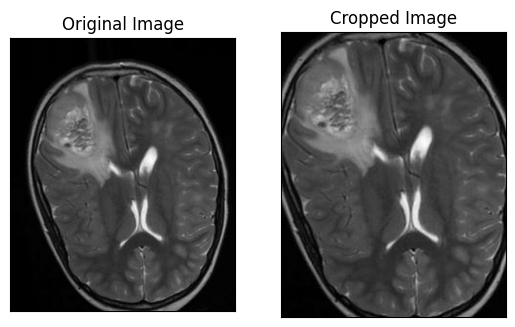

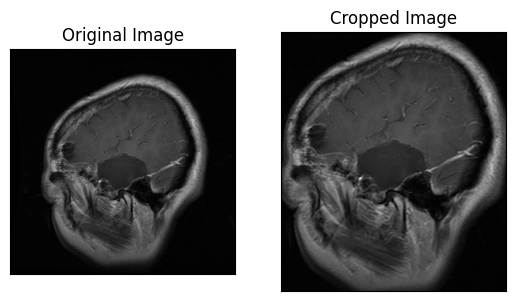

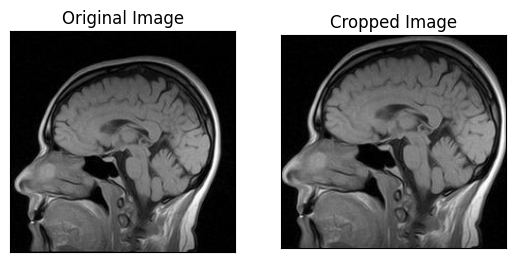

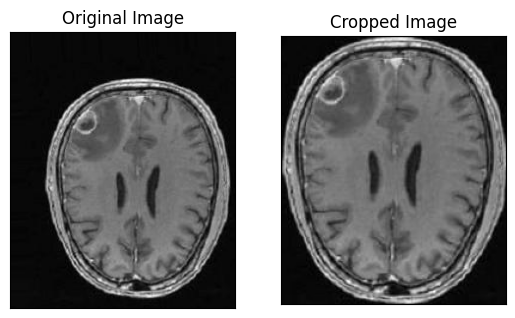

In [ ]:
import cv2
import os

image_path = '/content/drive/My Drive/fMRI data/yes/Y1.jpg'
image_path2 = '/content/drive/My Drive/fMRI data/yes/Y1024.jpg'
image_path3 = '/content/drive/My Drive/fMRI data/no/N978.jpg'
image_path4 =  '/content/drive/My Drive/fMRI data/no/N400.jpg' # N400... If you know, you know ;)

for path in [image_path, image_path2, image_path3, image_path4]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Image file not found: {path}")

ex_img = cv2.imread(image_path)
ex_img1 = cv2.imread(image_path2)
ex_img2 = cv2.imread(image_path3)
ex_img3 = cv2.imread(image_path4)

# Verify if the image was loaded successfully
# Raising an error if failed to load ;P
if ex_img is None:
    raise ValueError(f"Failed to load image from: {image_path}") #yes
if ex_img1 is None:
    raise ValueError(f"Failed to load image from: {image_path2}") #yes
if ex_img2 is None:
    raise ValueError(f"Failed to load image from: {image_path3}") #no
if ex_img3 is None:
    raise ValueError(f"Failed to load image from: {image_path4}") #no

ex_new_img = crop_brain_contour(ex_img, True)
ex_new_img1 = crop_brain_contour(ex_img1, True)
ex_new_img2 = crop_brain_contour(ex_img2, True)
ex_new_img3 = crop_brain_contour(ex_img3, True)

### Load up the data:

The following function takes two arguments, the first one is a list of directory paths for the folders 'yes' and 'no' that contain the image data and the second argument is the image size, and for every image in both directories and does the following:
1. Read the image.
2. Crop the part of the image representing only the brain.
3. Resize the image (because the images in the dataset come in different sizes (meaning width, height and # of channels). So, we want all of our images to be (240, 240, 3) to feed it as an input to the neural network.
4. Apply normalization because we want pixel values to be scaled to the range 0-1.
5. Append the image to <i>X</i> and its label to <i>y</i>.<br>

After that, Shuffle <i>X</i> and <i>y</i>, because the data is ordered (meaning the arrays contains the first part belonging to one class and the second part belonging to the other class, and we don't want that).<br>
Finally, Return <i>X</i> and <i>y</i>.

In [ ]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them.
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size

    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory + '/' + filename)

            # Checking if the image was loaded successfully
            if image is None:
                print(f"Error loading image: {directory}/{filename}")
                continue
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            image = image / 255.
            X.append(image)
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])

    X = np.array(X)
    y = np.array(y)

    # Shuffle the data
    X, y = shuffle(X, y)

    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y

Load up the data that we augmented earlier in the Data Augmentation notebook.<br>
**Note:** the augmented data directory contains not only the new generated images but also the original images.

In [ ]:
import os
from sklearn.model_selection import train_test_split  # Ensure train_test_split is imported

# Define image dimensions BEFORE using them
IMG_WIDTH, IMG_HEIGHT = (240, 240)

# Define the path to the augmented data in your Google Drive
augmented_path = '/content/drive/My Drive/fMRI data/'

# Load ONLY ORIGINAL DATA
original_yes = '/content/drive/My Drive/fMRI data/yes'  # Original tumor
original_no = '/content/drive/My Drive/fMRI data/no'    # Original non-tumor

# Load data with correct image dimensions
X_orig, y_orig = load_data([original_yes, original_no], (IMG_WIDTH, IMG_HEIGHT))

# Split FIRST before augmentation
X_train, X_temp, y_train, y_temp = train_test_split(X_orig, y_orig, test_size=0.3, stratify=y_orig)

# Split validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)



Number of examples is: 2267
X shape is: (2267, 240, 240, 3)
y shape is: (2267, 1)


### Plot sample images:

In [ ]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))

        i = 1 # current plot
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            # remove ticks
            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

# Display the Images 🧠
These images consist of horizontal, saggital, and coronal slices of the brain

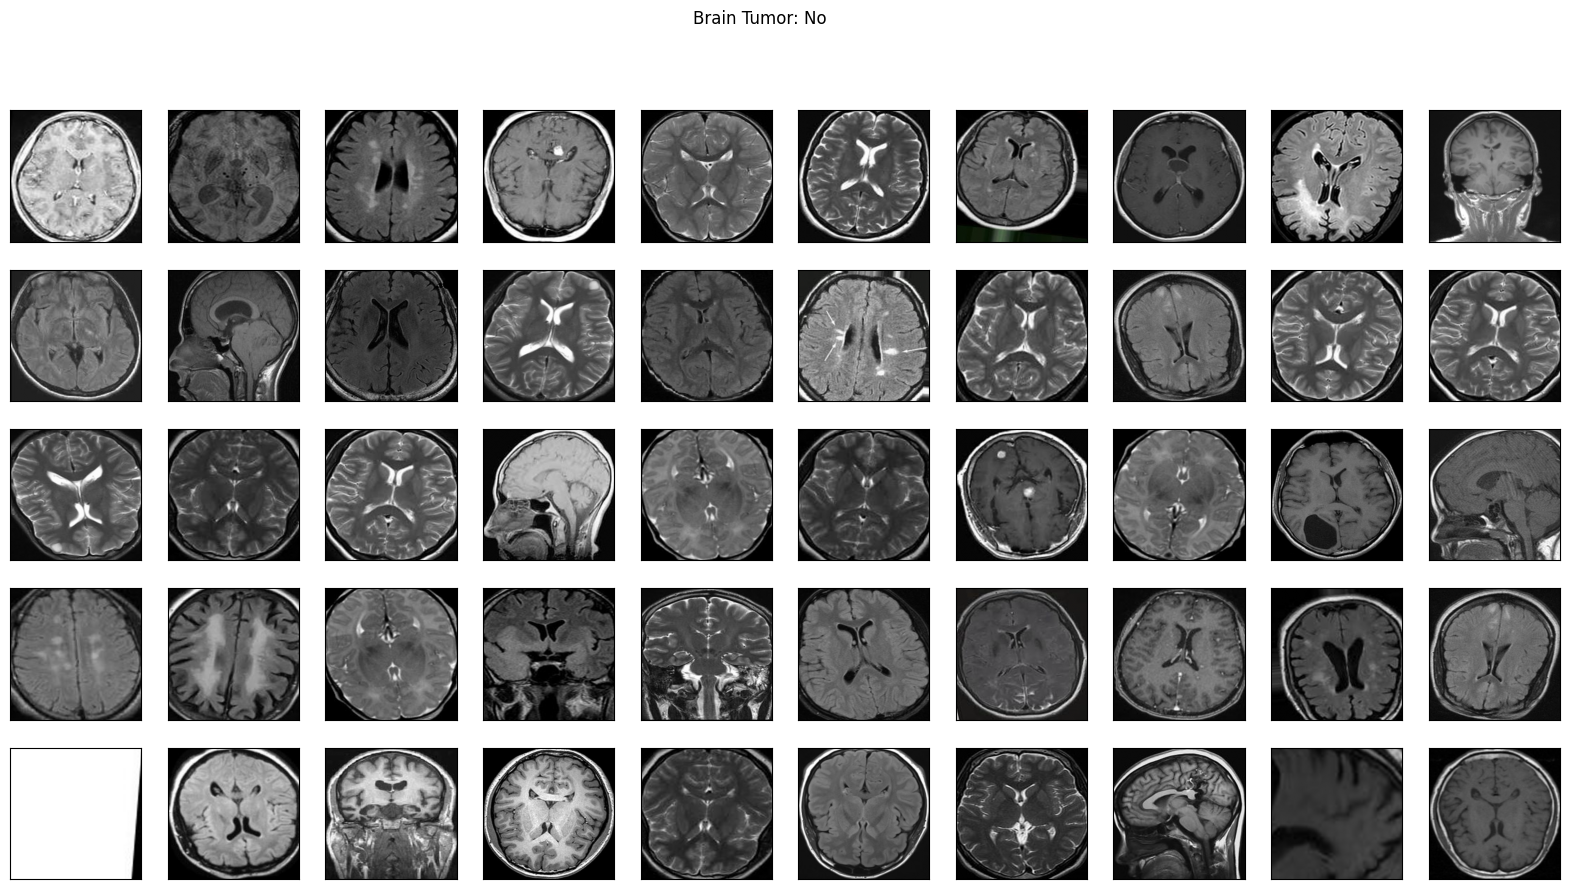

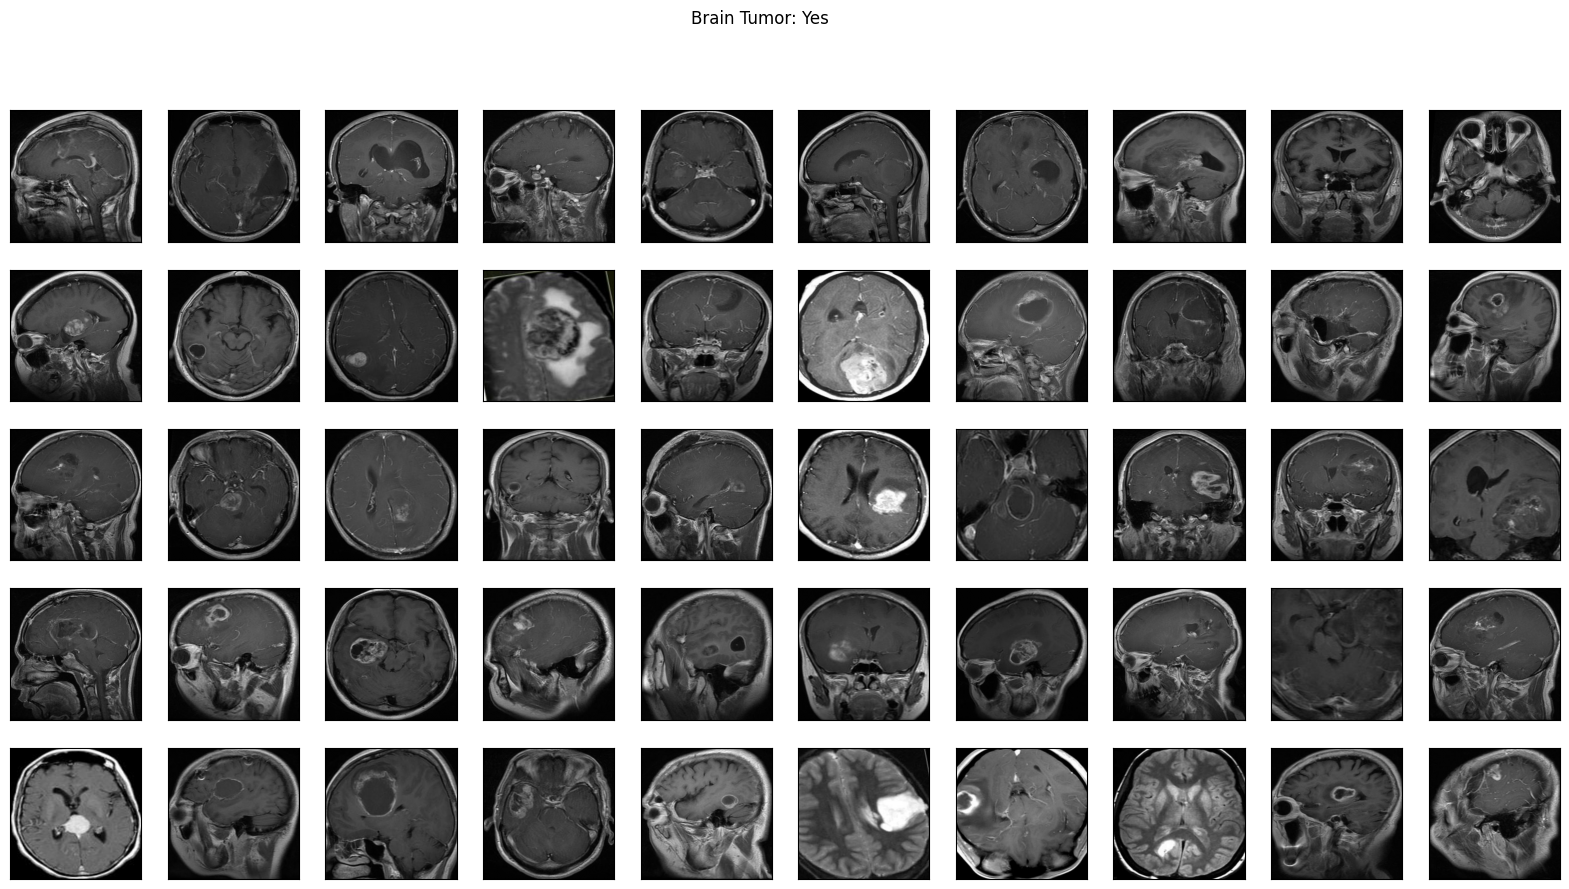

In [ ]:
plot_sample_images(X_orig, y_orig)

### Split the data:
Split <i>X</i> and <i>y</i> into training, validation (development) and validation sets.

In [ ]:
def split_data(X_orig, y_orig, test_size=0.2):

    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """

    X_train, X_test_val, y_train, y_test_val = train_test_split(X_orig, y_orig, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)

    return X_train, y_train, X_val, y_val, X_test, y_test

Splitting the data in the following way:<br>
1. 70% of the data for training.
2. 15% of the data for validation.
3. 15% of the data for testing.

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X_orig, y_orig, test_size=0.3)

In [ ]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1586
number of development examples = 341
number of test examples = 340
X_train shape: (1586, 240, 240, 3)
Y_train shape: (1586, 1)
X_val (dev) shape: (341, 240, 240, 3)
Y_val (dev) shape: (341, 1)
X_test shape: (340, 240, 240, 3)
Y_test shape: (340, 1)


*Some helper functions*:

In [ ]:
# Nicely formatted time string ;)
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [ ]:
def compute_f1_score(y_true, prob):
    y_pred = np.where(prob > 0.5, 1, 0)

    score = f1_score(y_true, y_pred)

    return score

# Build the model 🛠️

Building a convolutional neural network model:

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout # Import GlobalAveragePooling2D and Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

def build_model(input_shape):
    model = tf.keras.Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(128, (3,3), activation='relu'),
        GlobalAveragePooling2D(),
        Dropout(0.5),  # This is to reduce overfitting :)
        Dense(1, activation='sigmoid')
    ])
    return model

Define the image shape:

In [ ]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [ ]:
model = build_model(IMG_SHAPE)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 238, 238, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 119, 119, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 117, 117, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 58, 58, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,377 (364.75 KB)

 Trainable params: 93,377 (364.75 KB)

 Non-trainable params: 0 (0.00 B)

Compile the model:

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

filepath = "models/cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}.keras"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


## Train the model

In [ ]:
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

if not os.path.exists('/content/drive/My Drive/models'):
    os.makedirs('/content/drive/My Drive/models')

filepath = "/content/drive/My Drive/models/cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}.keras"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

model_files = [f for f in os.listdir('/content/drive/My Drive/models') if f.endswith('.keras')]

if not model_files:
    raise FileNotFoundError("No model files found in '/content/drive/My Drive/models' directory.")


best_model_file = max(model_files, key=lambda x: float(x.split('-')[3].split('.')[0]))

# Loading the best model
best_model = load_model(filepath=os.path.join('/content/drive/My Drive/models', best_model_file))

print(f"Best model loaded: {best_model_file}")

Best model loaded: cnn-parameters-improvement-05-0.86.keras


Training for a few more epochs:

In [ ]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5574 - loss: 0.6763
Epoch 1: val_accuracy improved from -inf to 0.56598, saving model to /content/drive/My Drive/models/cnn-parameters-improvement-01-0.57.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - accuracy: 0.5571 - loss: 0.6764 - val_accuracy: 0.5660 - val_loss: 0.6633
Epoch 2/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5612 - loss: 0.6680
Epoch 2: val_accuracy improved from 0.56598 to 0.57478, saving model to /content/drive/My Drive/models/cnn-parameters-improvement-02-0.57.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.5611 - loss: 0.6680 - val_accuracy: 0.5748 - val_loss: 0.6410
Epoch 3/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5979 - loss: 0.6442
Epoch 3: val_accuracy improved from 0.57478 to 0.70674, saving model to /content/drive/My Drive/models/cnn-parameters-improvement-03-0.71.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.5985 - loss: 0.6440 - val_accuracy: 0.7

In [ ]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7225 - loss: 0.6100
Epoch 1: val_accuracy did not improve from 0.70674
50/50 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.7225 - loss: 0.6099 - val_accuracy: 0.6422 - val_loss: 0.6072
Epoch 2/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6829 - loss: 0.6249
Epoch 2: val_accuracy improved from 0.70674 to 0.78592, saving model to /content/drive/My Drive/models/cnn-parameters-improvement-02-0.79.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.6830 - loss: 0.6247 - val_accuracy: 0.7859 - val_loss: 0.5907
Epoch 3/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7527 - loss: 0.5969
Epoch 3: val_accuracy did not improve from 0.78592
50/50 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.7529 - loss: 0.5967 - val_accuracy: 0.7801 - val_loss: 0.5584
Elapsed time: 0:6:14.4


In [ ]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7453 - loss: 0.5719
Epoch 1: val_accuracy did not improve from 0.78592
50/50 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.7457 - loss: 0.5717 - val_accuracy: 0.7478 - val_loss: 0.5388
Epoch 2/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7429 - loss: 0.5740
Epoch 2: val_accuracy improved from 0.78592 to 0.85631, saving model to /content/drive/My Drive/models/cnn-parameters-improvement-02-0.86.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.7434 - loss: 0.5735 - val_accuracy: 0.8563 - val_loss: 0.5311
Epoch 3/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7782 - loss: 0.5338
Epoch 3: val_accuracy did not improve from 0.85631
50/50 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.7784 - loss: 0.5336 - val_accuracy: 0.8240 - val_loss: 0.4899
Elapsed time: 0:6:14.7


In [ ]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8077 - loss: 0.4933
Epoch 1: val_accuracy did not improve from 0.85631
50/50 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.8078 - loss: 0.4931 - val_accuracy: 0.8475 - val_loss: 0.4687
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8433 - loss: 0.4430
Epoch 2: val_accuracy did not improve from 0.85631
50/50 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.8429 - loss: 0.4434 - val_accuracy: 0.8387 - val_loss: 0.4526
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8262 - loss: 0.4675
Epoch 3: val_accuracy improved from 0.85631 to 0.88270, saving model to /content/drive/My Drive/models/cnn-parameters-improvement-03-0.88.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.8266 - loss: 0.4670 - val_accuracy: 0.8827 - val_loss: 0.4491
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8418 - loss: 0.4592
Epoch 4: val_accuracy did not improve from 0.88270
50/50 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
history = model.history.history

In [ ]:
for key in history.keys():
    print(key)

accuracy
loss
val_accuracy
val_loss


## Plot Loss & Accuracy

In [ ]:
def plot_metrics(history):

    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']

    # Plotting the Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

    # Plotting the Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

**Note:** Since we trained the model using more than model.fit() function call, this made the history only contain the metric values of the epochs for the last call (which was for 5 epochs), so to plot the metric values across the whole process of trianing the model from the beginning, I had to grab the rest of the values.

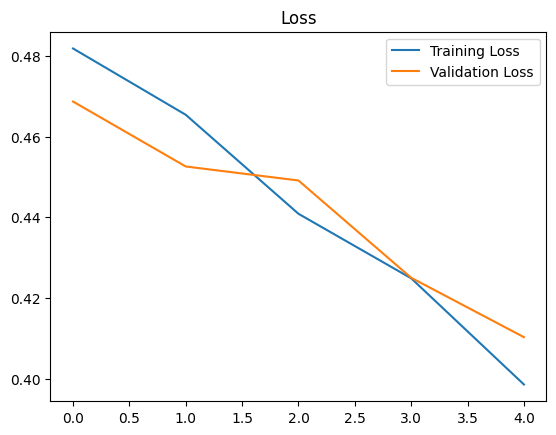

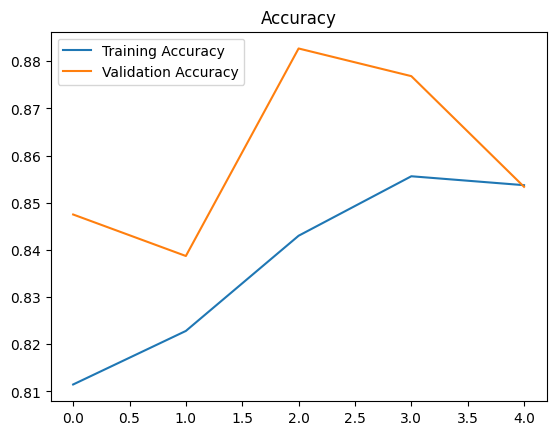

In [ ]:
plot_metrics(history)



# Results + Interpretation 📈

Taking a look at the number of positive and negative examples in the dataset:<br>
positive = glioblastoma present<br>
negative = healthy brain<br>

In [ ]:
def data_percentage(y):

    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive

    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m

    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}")
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}")



In [ ]:
# the whole data
data_percentage(y_orig)

Number of examples: 2267
Percentage of positive examples: 45.169827966475516%, number of pos examples: 1024
Percentage of negative examples: 54.830172033524484%, number of neg examples: 1243


In [ ]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1586
Percentage of positive examples: 45.775535939470366%, number of pos examples: 726
Percentage of negative examples: 54.224464060529634%, number of neg examples: 860
Validation Data:
Number of examples: 341
Percentage of positive examples: 43.401759530791786%, number of pos examples: 148
Percentage of negative examples: 56.598240469208214%, number of neg examples: 193
Testing Data:
Number of examples: 340
Percentage of positive examples: 44.11764705882353%, number of pos examples: 150
Percentage of negative examples: 55.88235294117647%, number of neg examples: 190


# Conclusion:

In [ ]:
from sklearn.metrics import f1_score

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Model Loss for test set: {test_loss}")
print(f"Model Accuracy for test set: {test_accuracy}")

y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# getting the f1 score
f1 = f1_score(y_test, y_pred_binary)

print(f"F1 Score: {f1}")


11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 591ms/step - accuracy: 0.8371 - loss: 0.4002
Model Loss for test set: 0.3835466206073761
Model Accuracy for test set: 0.8470588326454163
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 612ms/step
F1 Score: 0.8129496402877698


In [ ]:
# Code adapted from https://github.com/MohamedAliHabib/Brain-Tumor-Detection
# This file was modified from its original version from: https://github.com/MohamedAliHabib/Brain-Tumor-Detection
# Licensed under the Apache License 2.0